In [11]:
# !python3 -m pip install xgboost
# !python3 -m pip install scikit-learn 

In [12]:
import xarray as xr
from xgboost import XGBClassifier
import sklearn
import numpy as np

In [13]:
RUN_NAME = "LW_CLM_Ex4"
ds = xr.open_dataset(f'{RUN_NAME}/training_data.nc')
data = ds.to_dataframe()
data = data[data['pressure'] < 0]
data

pressure  saturation  \
time          y          x                                  
873813.656485 1091243874 2133009608 -0.136915   -0.136608   
                         1093115616 -0.146506   -0.146786   
                         0          -0.147010   -0.147284   
                         1093115616 -0.163042   -0.163914   
                         0          -0.154552   -0.155101   
...                                       ...         ...   
224553.521236 1093107855 289042709  -0.383211   -0.329032   
                         1093323616 -0.358171   -0.281139   
                         0          -0.471598   -0.421268   
                         1091246615 -1.414911   -1.402555   
                         973033431  -2.690493   -2.679152   

                                     pressure_becomes_positive    volume  \
time          y          x                                                 
873813.656485 1091243874 2133009608                  -0.076170  0.997903   
                         1093115616                  -0.080463  0.997447   
                         0                           -0.081752  0.997387   
                         1093115616                  -0.096955  0.996190   
                         0                           -0.089473  0.996832   
...                                                        ...       ...   
224553.521236 1093107855 289042709                    0.994828  1.000000   
                         1093323616                   0.996481  1.000000   
                         0                            0.989969  0.998892   
                         1091246615                   0.813583  0.822792   
                         973033431                    0.485053  0.491363   

                                     max_volume   flux_in  runtime_pressure  \
time          y          x                                                    
873813.656485 1091243874 2133009608    0.992710  0.994305               0.0   
                         1093115616    0.991329  0.993116               0.0   
                         0             0.991274  0.993061               0.0   
                         1093115616    0.988852  0.990891               0.0   
                         0             0.990190  0.992086               0.0   
...                                         ...       ...               ...   
224553.521236 1093107855 289042709     0.996848  0.000000               0.0   
                         1093323616    0.999468  0.000000               0.0   
                         0             0.993637  0.000000               0.0   
                         1091246615    0.817387  0.000000               0.0   
                         973033431     0.487554  0.000000               0.0   

                                     we_predicted  predicted_pressure  \
time          y          x                                              
873813.656485 1091243874 2133009608         False            0.000000   
                         1093115616         False            0.000000   
                         0                  False            0.000000   
                         1093115616         False            0.000000   
                         0                  False            0.000000   
...                                           ...                 ...   
224553.521236 1093107855 289042709          False       639066.000546   
                         1093323616         False       852366.210512   
                         0                  False       420865.825126   
                         1091246615         False       439422.154884   
                         973033431          False       811734.580801   

                                         elevation  permeability_x  \
time          y          x                                           
873813.656485 1091243874 2133009608  221910.302992   221887.157890   
                         1093115616  221875.229372   221852.097278

In [14]:
features = [
    "pressure", "saturation", "volume", "max_volume", "flux_in", "we_predicted", 
    "permeability_x", "permeability_y", "permeability_z", "porosity", "specific storage", "mannings"
    ]
target = ["pressure_becomes_positive"]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data[features], data[target], test_size=.2)
# # create model instance
# boost = XGBClassifier(n_estimators=10, max_depth=4, learning_rate=1, objective='binary:logistic')
# # fit model
# boost.fit(x_train, y_train)
# # make predictions
# preds = boost.predict(x_test)

In [15]:
from sklearn.linear_model import RidgeClassifier

linear_model = RidgeClassifier().fit(x_train, y_train)

preds = linear_model.predict(x_test)

disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_test[target],
    preds,
    display_labels=["Doesn't Switch", "Switches"]
    )
disp.ax_.set_title("Confusion matrix for our Linear predictor")

ValueError: Unknown label type: (array([[ 0.27600478],
       [ 0.18904335],
       [-0.07132269],
       ...,
       [-0.14323811],
       [ 0.25797726],
       [-0.79583854]]),)

In [16]:
params = {
            'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 1.0],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.5, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
            'n_estimators': [25, 50, 100],
            'max_depth': [2,4,8,16]
        }

xgbclf = XGBClassifier(objective="binary:logistic")
model = sklearn.model_selection.RandomizedSearchCV(estimator=xgbclf,
                            param_distributions=params,
                            scoring='accuracy',
                            n_iter=5,
                            n_jobs=4,
                            verbose=1)

model.fit(x_train, y_train)


best_combination = model.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [    0     1     2 ... 45486 45487 45488], got [-3.76373404 -3.7504625  -3.75025302 ...  0.99999009  0.99999254
  1.        ]

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [    0     1     2 ... 45500 45501 45502], got [-3.76373404 -3.76277254 -3.75025302 ...  0.99998866  0.99999009
  1.        ]

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [    0     1     2 ... 45484 45485 45486], got [-3.76373404 -3.76277254 -3.7504625  ...  0.99998866  0.99999254
  1.        ]

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [    0     1     2 ... 45491 45492 45493], got [-3.76277254 -3.7504625  -3.75025302 ...  0.99999009  0.99999254
  1.        ]

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/anaconda3/envs/icom2/lib/python3.9/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [    0     1     2 ... 45473 45474 45475], got [-3.76373404 -3.76277254 -3.7504625  ...  0.99999009  0.99999254
  1.        ]


In [ ]:
best_model = model.best_estimator_
preds = best_model.predict(x_test)
print(best_combination)

{'subsample': 0.7999999999999999, 'n_estimators': 50, 'max_depth': 16, 'learning_rate': 0.3, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.5}


Text(0.5, 1.0, 'Confusion matrix for our XGBoost predictor')

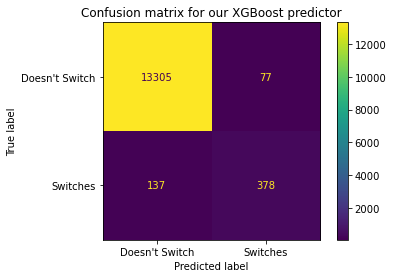

In [ ]:
disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_test[target], 
    preds,
    display_labels=["Doesn't Switch", "Switches"]
    )
disp.ax_.set_title("Confusion matrix for our XGBoost predictor")

Text(0.5, 1.0, "Confusion matrix for Parflow's current predictor")

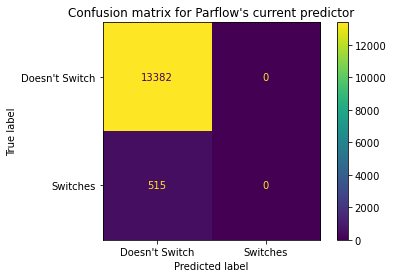

In [ ]:
disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_test[target], x_test["we_predicted"], 
    display_labels=["Doesn't Switch", "Switches"],

    )
disp.ax_.set_title("Confusion matrix for Parflow's current predictor")

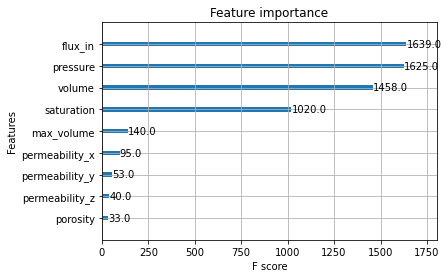

In [ ]:
from matplotlib import pyplot

# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(best_model)
pyplot.show()